In [10]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# import pandas as pd
# import os

# # Load the dataset
# file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/IDoFT_dataset.csv"
# data = pd.read_csv(file_path)

# # Extract the relevant fields: 'preprocessed_code' and 'category'
# relevant_data = data[['preprocessed_code', 'category']]

# # Filter out the categories to include only 0, 1, 2, 3, 4, and 5
# filtered_data = relevant_data[relevant_data['category'].isin([0, 1, 2, 3, 4, 5])]

# # Sample 50 points from each category
# sampled_data = filtered_data.groupby('category', group_keys=False).apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

# # Print the sampled data
# print(sampled_data)

# # Process filenames and categories
# categories = {}

# # Assuming that the filenames are in a specific directory
# directory_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/"
# filenames = next(os.walk(directory_path), (None, None, []))[2]

# for file in filenames:
#     if "@" in file:
#         label = (file.split("@")[1]).split('.')[0].strip().lower()
#         if label not in categories.keys():
#             categories[label] = 0
#         categories[label] += 1

# print("\n==> All data : \n")
# for x, y in categories.items():
#     print(x, y)


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# # Load the dataset
# file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/IDoFT_dataset.csv"
# data = pd.read_csv(file_path)

# # Extract the relevant fields: 'preprocessed_code' and 'category'
# relevant_data = data[['preprocessed_code', 'category']]

# # Filter out the categories to include only 0, 1, 2, 3, 4, and 5
# filtered_data = relevant_data[relevant_data['category'].isin([0, 1, 2, 3, 4, 5])]

# # Sample up to 200 points from each category or whatever is available
# sampled_data = filtered_data.groupby('category', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 200), random_state=42)).reset_index(drop=True)

# # Split the sampled data into training and validation sets
# train_data, valid_data = train_test_split(sampled_data, test_size=0.2, random_state=42)

# # Extract buggy code and categories for train and validation sets
# train_buggy_code = train_data['preprocessed_code'].tolist()
# valid_buggy_code = valid_data['preprocessed_code'].tolist()
# train_categories = train_data['category'].tolist()
# valid_categories = valid_data['category'].tolist()

file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/IDoFT_dataset.csv"
data = pd.read_csv(file_path)

# Extract the relevant fields: 'preprocessed_code' and 'category'
relevant_data = data[['preprocessed_code', 'category']]

# Filter the data to include only categories 0, 1, 2, 3, and 4
filtered_data = relevant_data[relevant_data['category'].isin([0, 1, 2, 3, 4, 5])]

# Split the data into training and validation sets
train_data, valid_data = train_test_split(filtered_data, test_size=0.2, random_state=42)

# Extract buggy code and categories for train and validation sets
train_buggy_code = train_data['preprocessed_code'].tolist()
valid_buggy_code = valid_data['preprocessed_code'].tolist()
train_categories = train_data['category'].tolist()
valid_categories = valid_data['category'].tolist()

# Print the splits for verification
print("Train buggy code:", len(train_buggy_code))
print("Validation buggy code:", len(valid_buggy_code))
print("Train categories:", len(train_categories))
print("Validation categories:", len(valid_categories))

# Process filenames and categories
categories = {}

# Assuming that the filenames are in a specific directory
directory_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/"
filenames = next(os.walk(directory_path), (None, None, []))[2]

for file in filenames:
    if "@" in file:
        label = (file.split("@")[1]).split('.')[0].strip().lower()
        if label not in categories.keys():
            categories[label] = 0
        categories[label] += 1

print("\n==> All data : \n")
for x, y in categories.items():
    print(x, y)


Train buggy code: 2553
Validation buggy code: 639
Train categories: 2553
Validation categories: 639

==> All data : 



In [14]:
label_to_int= {
    'OD': 0,
    'NIO': 1,
    'ID': 2,
    'NDOD': 3,
    'NOD': 4,
    'UD':5
}

In [15]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, categories, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.categories = categories
        self.split = split
        self.max_len = 0
        
        # Preprocess categories to map labels to indices
        self.label_to_indices = {}
        for index, category in enumerate(categories):
            if category not in self.label_to_indices:
                self.label_to_indices[category] = []
            self.label_to_indices[category].append(index)

        # For negative sampling
        self.labels = categories
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self.categories[idx]

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])

            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, 13824 - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, 13824 - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, 13824 - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split == 'val':
            anchor_label = self.categories[idx]
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, 13824 - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _process_snippet(self, snippet):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:
            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:
            total_length = inputs['input_ids'].shape[1]
            # if total_length >= self.max_len:
            #     self.max_len = total_length
            #     print(self.max_len)
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts




In [16]:
# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_categories, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_categories, 'val')

# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Print the lengths of the dataloaders for verification
print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))

Train dataloader length: 320
Validation dataloader length: 80


In [17]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [18]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

 61%|██████    | 1546/2553 [00:13<00:09, 106.48it/s]

In [ ]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor['anchor'].size(0) for tensor in train_dataset)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [ ]:
max_length

13824

In [ ]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']  
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


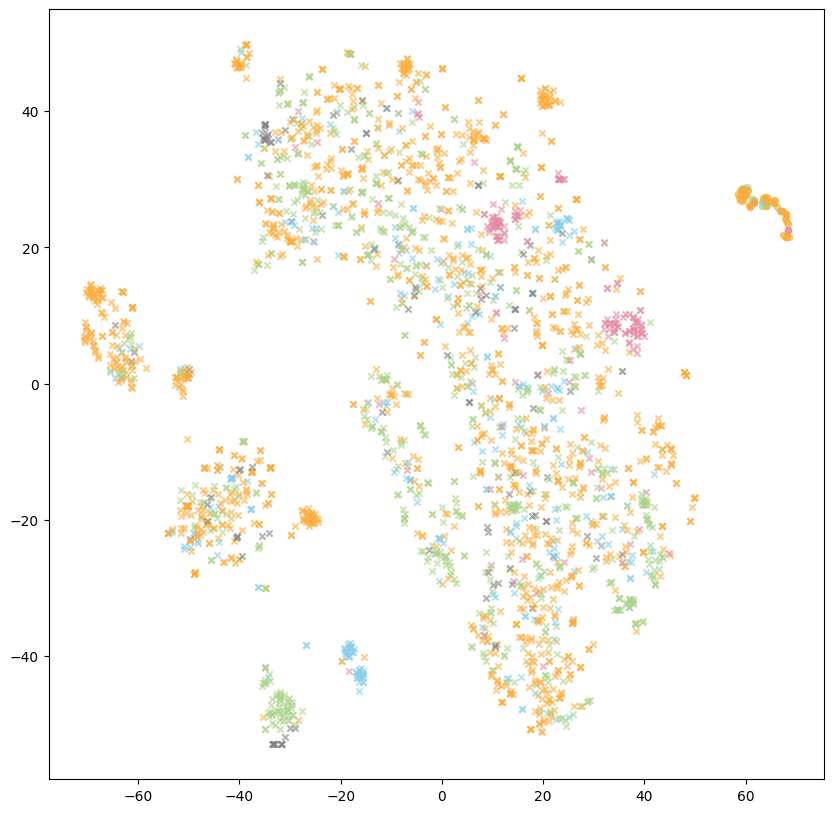

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
# plt.gca().set_facecolor('white')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.xlabel('Component 1', color='white')
# plt.ylabel('Component 2', color='white')

plt.show()


In [ ]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


# class SiameseNetwork(nn.Module):
#     def __init__(self, embedding_size):
#         super(SiameseNetwork, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(embedding_size, int(embedding_size/2)),
#             nn.ReLU(inplace=True),
#             nn.Linear(int(embedding_size/2), int(embedding_size/4)),
#             nn.ReLU(inplace=True),
#             nn.Linear(int(embedding_size/4), embedding_size)
#         )

#     def forward(self, x):
#         output = self.fc(x)
#         return output


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(embedding_size, int(embedding_size / 2))
        self.fc2 = nn.Linear(embedding_size, int(embedding_size/2))
        self.relu1 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(int(embedding_size / 2), int(embedding_size / 2))
        self.relu2 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(int(embedding_size / 2), embedding_size)
        

    def forward(self, x):

        skip_conn = self.fc1(x)
        out = self.fc2(x)
        out = self.relu1(out)
        out = self.fc3(out)
        out+= skip_conn
        out = self.relu2(out)
        out = self.fc4(out)


        return out

In [ ]:
from collections import Counter

# Assuming 'train_dataloader' yields batches of data with 'label' key
class_counts = Counter()
for batch in train_dataloader:
    class_counts.update(batch['label'].cpu().numpy())

total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Convert to tensor and normalize
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32).to(device)
#class_weights_tensor = class_weights_tensor / class_weights_tensor.max()

In [ ]:
class_weights_tensor

tensor([1.0000, 0.3492, 0.0905, 0.0508, 0.4099, 0.6000], device='cuda:0')

In [ ]:
# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         distance_positive = (anchor - positive).pow(2).sum(1)
#         distance_negative = (anchor - negative).pow(2).sum(1)
#         losses = torch.relu(distance_positive - distance_negative + self.margin)
#         return losses.mean()
    

class WeightedTripletLoss(nn.Module):
    def __init__(self, margin=1.0, class_weights=None):
        super(WeightedTripletLoss, self).__init__()
        self.margin = margin
        self.class_weights = class_weights if class_weights is not None else torch.ones(1).to(device)

    def forward(self, anchor, positive, negative, labels):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        # Apply class-specific weights
        if self.class_weights is not None:
            labels = labels.to(self.class_weights.device)
            weights = self.class_weights[labels]
            losses = losses * weights

        return losses.mean()

In [ ]:
learning_rate = 1e-5
num_epochs = 600
embed_size = 13824  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = WeightedTripletLoss(margin=1.0, class_weights=class_weights_tensor)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = WeightedTripletLoss().to(device)

In [ ]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

600 epochs done

In [ ]:
from tqdm import tqdm
best_loss = 100.0
# num_epochs = 200
epoch_loss_list = []
for epoch in range(num_epochs):
    total_loss = 0.0
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out, labels)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()  

        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'FlakyXbert_IDoFT_full_epoch1200_skip_connection.pth')
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    # The line `epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")` is attempting to append a formatted string to a list named `epoch_loss_list`. This string contains information about the current epoch number, total number of epochs, and the average loss calculated for that epoch. However, in the provided code snippet, the `epoch_loss_list` list is not defined or used anywhere else in the code.
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

  0%|          | 0/320 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 320/320 [00:40<00:00,  7.90it/s]


Epoch 1/600, Loss: 0.1703298510168679


  0%|          | 0/320 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 320/320 [00:41<00:00,  7.79it/s]


Epoch 2/600, Loss: 0.14258188581443393


  0%|          | 0/320 [00:00<?, ?it/s]

Loss improved saving model


  5%|▍         | 15/320 [00:03<00:33,  8.98it/s]

In [ ]:
epoch_loss_list[:20]

NameError: name 'epoch_loss_list' is not defined

In [ ]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [ ]:
siamese_network.load_state_dict(torch.load('FlakyXbert_IDoFT_full_epoch1200_skip_connection.pth'))


<All keys matched successfully>

In [ ]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 2553/2553 [00:26<00:00, 96.73it/s] 


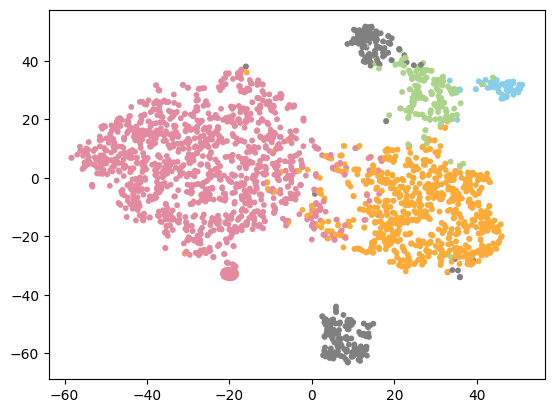

In [ ]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap= cc , alpha=1 )


In [ ]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=218, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 6
    for label in range(6):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [ ]:
int_to_label={
    0: 'OD',
    1: 'NIO',
    2: 'ID',
    3: 'NDOD',
    4: 'NOD',
    5: 'UD'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [ ]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

NOD
NOD


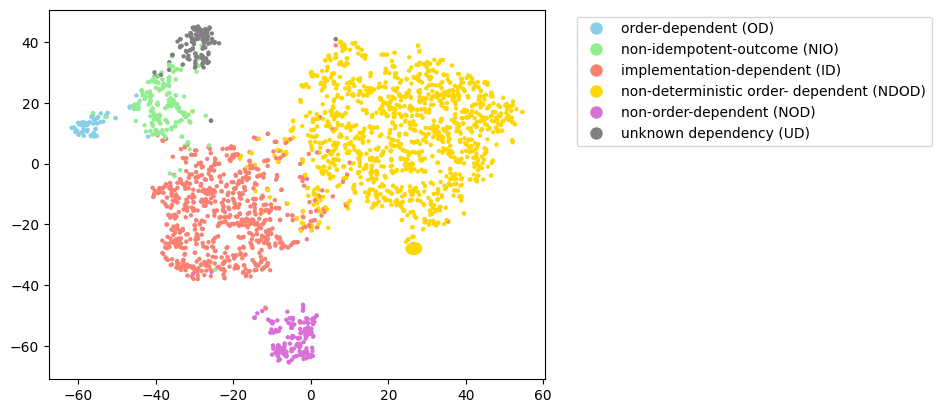

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed and post_train_label are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Ensure labels are within the range of colors [0, 1, 2, 3, 4]
# Filter out invalid labels (-1) and keep only valid labels [0, 1, 2, 3, 4]
valid_indices = [i for i, label in enumerate(labelsNums) if label in [0, 1, 2, 3, 4, 5]]
X_np_filtered = X_np[valid_indices]
labelsNums_filtered = [labelsNums[i] for i in valid_indices]

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np_filtered)

# Scatter plot
for i, label in enumerate(labelsNums_filtered):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
legend_labels = ['order-dependent (OD)', 'non-idempotent-outcome (NIO)', 'implementation-dependent (ID)', 'non-deterministic order- dependent (NDOD)', 'non-order-dependent (NOD)', 'unknown dependency (UD)']
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels,bbox_to_anchor=(1.05, 1), 
                    loc='upper left')

plt.show()


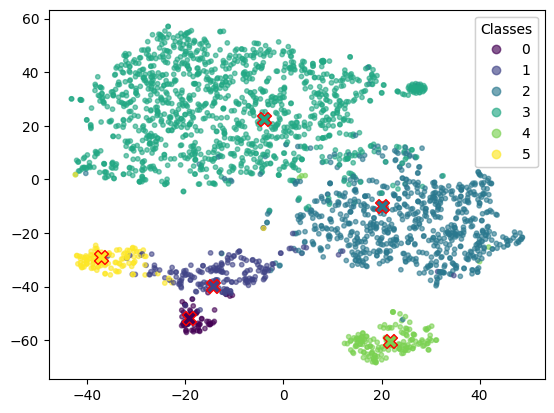

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [ ]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [ ]:
from sklearn.metrics import f1_score

int_to_label={
    0: 'OD',
    1: 'NIO',
    2: 'ID',
    3: 'NDOD',
    4: 'NOD',
    5: 'UD'
}

label_to_int = {v: k for k, v in int_to_label.items()}  # Create reverse mapping

count = 0

# Assuming val_dataset is iterable and has 'anchor' and 'label' keys
predicted_labels = []
true_labels = []

for item in val_dataset:
    count += 1
    input_vector = item['anchor']  # Your input vector for prediction
    
    # Get predicted cluster/label
    predicted_label_str = predict(input_vector)
    
    # Ensure predicted_label is in the valid range
    if predicted_label_str in label_to_int:
        predicted_label = label_to_int[predicted_label_str]
        predicted_labels.append(predicted_label)
    else:
        print(f"Warning: Encountered unknown predicted label {predicted_label_str}")
        continue

    # True label
    true_label_int = int(item['label'])  # Assuming 'label' contains the true label as integer
    if true_label_int in int_to_label:
        true_labels.append(true_label_int)
    else:
        print(f"Warning: Encountered unknown true label {true_label_int}")
        continue

    print(count, "Predicted:", predicted_label, "True:", true_label_int)

# Filter out any invalid entries where predicted or true labels are missing
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label and predicted_labels[i] in int_to_label]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

print("Loop completed")

# Calculate F1 Score, ignoring unknown labels
f1 = f1_score(filtered_true_labels, filtered_predicted_labels, average='weighted', zero_division=0)  # Adjust 'average' as necessary
print(f"F1 Score: {f1}")


1 Predicted: 1 True: 3
2 Predicted: 3 True: 3
3 Predicted: 2 True: 2
4 Predicted: 5 True: 2
5 Predicted: 5 True: 2
6 Predicted: 5 True: 1
7 Predicted: 3 True: 2
8 Predicted: 4 True: 4
9 Predicted: 3 True: 3
10 Predicted: 2 True: 2
11 Predicted: 2 True: 2
12 Predicted: 5 True: 3
13 Predicted: 3 True: 3
14 Predicted: 3 True: 2
15 Predicted: 3 True: 3
16 Predicted: 3 True: 1
17 Predicted: 3 True: 3
18 Predicted: 3 True: 3
19 Predicted: 5 True: 5
20 Predicted: 5 True: 4
21 Predicted: 3 True: 3
22 Predicted: 5 True: 5
23 Predicted: 1 True: 5
24 Predicted: 3 True: 3
25 Predicted: 2 True: 2
26 Predicted: 3 True: 3
27 Predicted: 2 True: 2
28 Predicted: 2 True: 3
29 Predicted: 3 True: 2
30 Predicted: 5 True: 3
31 Predicted: 2 True: 2
32 Predicted: 3 True: 3
33 Predicted: 5 True: 5
34 Predicted: 4 True: 3
35 Predicted: 2 True: 2
36 Predicted: 3 True: 3
37 Predicted: 3 True: 3
38 Predicted: 3 True: 3
39 Predicted: 3 True: 3
40 Predicted: 2 True: 2
41 Predicted: 4 True: 4
42 Predicted: 3 True: 3
4

              precision    recall  f1-score   support

           0       0.40      0.56      0.47        18
           1       0.22      0.43      0.29        37
           2       0.79      0.64      0.71       203
           3       0.88      0.78      0.83       318
           4       0.51      0.79      0.62        33
           5       0.39      0.60      0.47        30

    accuracy                           0.70       639
   macro avg       0.53      0.63      0.56       639
weighted avg       0.76      0.70      0.72       639


 - Accuracy :  0.7
 - Precision :  0.76
 - Recall :  0.7
 - F1 score :  0.72
 - MCC :  0.57
 - AUC :  0.81


Performances by categories



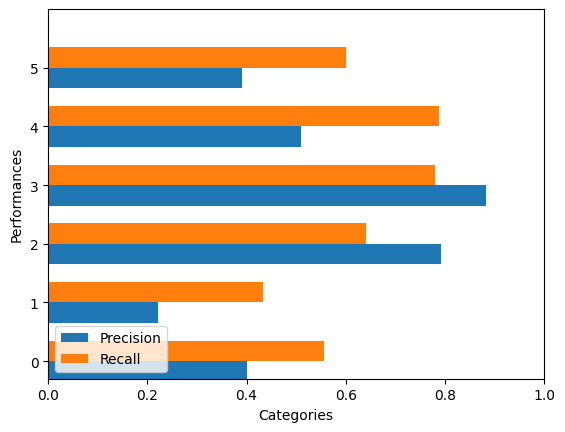



Confusion Matrix 


<AxesSubplot:>

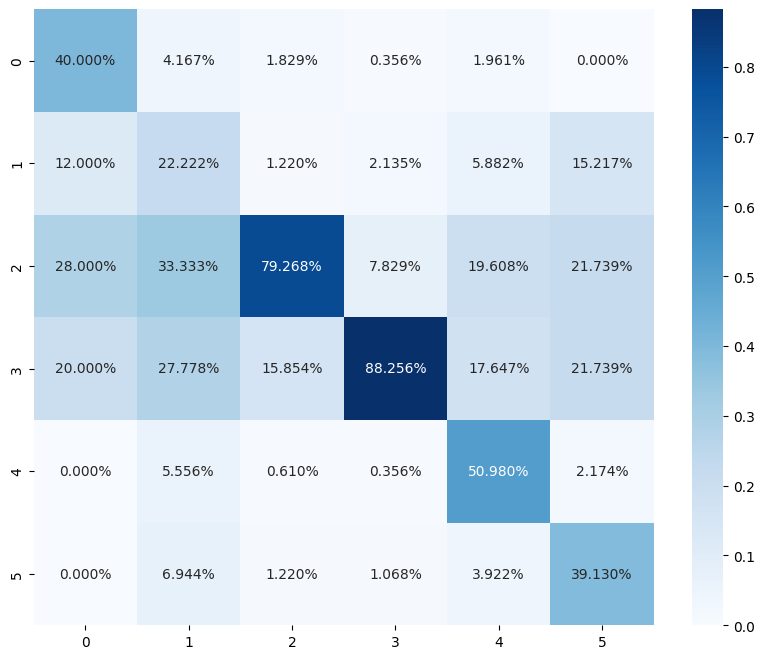

In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore")

def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

# Assuming predicted_labels and true_labels are already defined
predicted = predicted_labels
labels = true_labels

# Filter out 'unknown' labels
valid_indices = [i for i, label in enumerate(labels) if label != 'unknown']
filtered_labels = [labels[i] for i in valid_indices]
filtered_predicted = [predicted[i] for i in valid_indices]

unique_labels = list(set(filtered_labels))
print(classification_report(filtered_labels, filtered_predicted))

print('\n - Accuracy : ', np.round(metrics.accuracy_score(filtered_labels, filtered_predicted), 2))
print(' - Precision : ', np.round(metrics.precision_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - Recall : ', np.round(metrics.recall_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - F1 score : ', np.round(metrics.f1_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - MCC : ', np.round(metrics.matthews_corrcoef(filtered_labels, filtered_predicted), 2))
print(' - AUC : ', np.round(multiclass_roc_auc_score(filtered_labels, filtered_predicted), 2))

print("\n\nPerformances by categories\n")

ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[0]
recall = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind, yticklabels=np.array(unique_labels), ylim=[2*width - 1, len(ind)])
plt.xlim(0, 1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(filtered_labels, filtered_predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index=[i for i in unique_labels], columns=[i for i in unique_labels])
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm / np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')


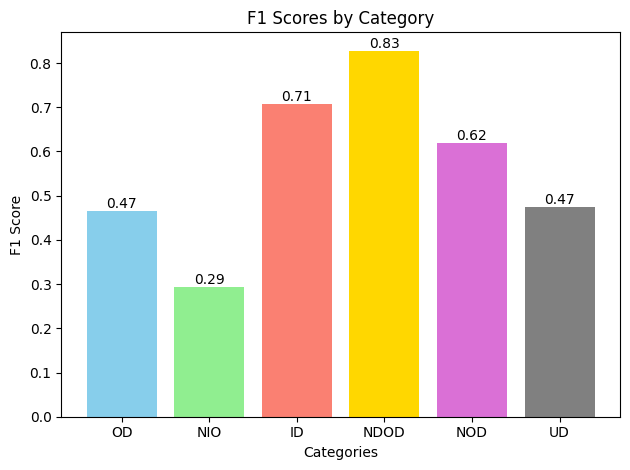

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label={
    0: 'OD',
    1: 'NIO',
    2: 'ID',
    3: 'NDOD',
    4: 'NOD',
    5: 'UD'
}

# Shortened category names
shortened_labels = {
    'OD': 'OD',
    'NIO': 'NIO',
    'ID': 'ID',
    'NDOD': 'NDOD',
    'NOD': 'NOD',
    'UD': 'UD'
}

# Filter out invalid labels from both true and predicted labels
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label.keys() and predicted_labels[i] in int_to_label.keys()]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.keys())
for category in categories:
    true_bin = [1 if label == category else 0 for label in filtered_true_labels]
    pred_bin = [1 if label == category else 0 for label in filtered_predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[int_to_label[category]] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# def extract_projections(siamese_network, dataloader):
#     projections = []
#     labels = []
#     for batch in dataloader:
#         label = batch["label"]
#         anchor = batch["anchor"]
#         projection = siamese_network(anchor)
        
#         projections.append(projection.cpu().detach().numpy())
#         labels.append(label.numpy())
#     projections = np.vstack(projections)
#     labels = np.hstack(labels)
#     return projections, labels

In [ ]:
# projections, labels = extract_projections(siamese_network, train_dataloader)
# val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

In [ ]:
# print(len(projections), len(train_dataloader))

In [ ]:
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(projections, labels)

# # Train SVM Classifier
# svm_classifier = SVC(kernel='linear', random_state=42)
# svm_classifier.fit(projections, labels)

In [ ]:
# # Evaluate Random Forest Classifier
# rf_predictions = rf_classifier.predict(val_projections)
# rf_accuracy = accuracy_score(val_labels, rf_predictions)
# rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
# print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# # Evaluate SVM Classifier
# svm_predictions = svm_classifier.predict(val_projections)
# svm_accuracy = accuracy_score(val_labels, svm_predictions)
# svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
# print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")